# Load the JSON files

In [1]:
import os
import warnings
warnings.simplefilter('ignore')

DATA_PATH = '/content/drive/MyDrive/DATASETS/NELA/'
NELA_2018_SITE_SPLIT = 'nela_gt_2018_site_split/'

if os.path.isdir(NELA_2018_SITE_SPLIT):
  !rm -r {NELA_2018_SITE_SPLIT}
!cp -r {DATA_PATH + NELA_2018_SITE_SPLIT} {NELA_2018_SITE_SPLIT}

In [2]:
import pandas as pd
import json
import numpy as np

def jsonl_to_df(file_path):
    with open(file_path) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [3]:
train_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'train.jsonl')
train_df['split'] = 'train'
dev_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'dev.jsonl')
dev_df['split'] = 'dev'
test_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'test.jsonl')
test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df])

In [4]:
table = pd.pivot_table(df, values='title', index=['split'], columns=['label'], aggfunc='count', margins='all')
table

label,0,1,All
split,,,
dev,20294,20294,40588
test,19410,19410,38820
train,35302,35302,70604
All,75006,75006,150012


In [5]:
df.fillna('', inplace=True)
df.sample(5)

,content,title,date,source,label,split
5233,Kate Hopkins from the UK is reporting that the...,French Protesters Riot in Reaction to Macrons ...,2018-11-25,thegatewaypundit,0,test
32529,"Disney Research, MIT Media Lab, and Carnegie M...",Disney made a jacket to simulate physical expe...,2018-04-26,theverge,1,test
18716,In a time when peoples faith in others needs t...,Single Mom Offered For Kids School Supplies To...,2018-10-01,trueactivist,0,test
22983,U.S. tech giants are merely extensions of the ...,The tectonic plates of geopolitics are shiftin...,2018-08-28,sottnet,0,dev
5082,A few weeks ago we were looking at some of the...,Swedish election ends in a virtual deadlock ov...,2018-09-10,hotair,1,dev


# Logistic Regression (Title only)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from scipy import sparse

vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [ ]:
X_train_vect = sparse.hstack([vect_word.fit_transform(X_train), vect_char.fit_transform(X_train)])
X_test_vect = sparse.hstack([vect_word.fit_transform(X_test), vect_char.fit_transform(X_test)])

In [ ]:
lr = LogisticRegression(C=1, max_iter=500, random_state = 42)
lr.fit(X_train_vect, y_train)

LogisticRegression(C=1, max_iter=500, random_state=42)

In [ ]:
y_pred = lr.predict(X_test_vect)

In [ ]:
print('\nConfusion matrix\n',confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Confusion matrix
 [[ 1725 17685]
 [ 1408 18002]]
              precision    recall  f1-score   support

           0       0.55      0.09      0.15     19410
           1       0.50      0.93      0.65     19410

    accuracy                           0.51     38820
   macro avg       0.53      0.51      0.40     38820
weighted avg       0.53      0.51      0.40     38820



# BERT (Title Only)

In [6]:
!pip install transformers --q
!pip install datasets --q
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --q
!pip install pytorch-lightning --q
!pip install torchmetrics --q

     |████████████████████████████████| 3.3 MB 30.4 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 61 kB 500 kB/s 
     |████████████████████████████████| 298 kB 17.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 243 kB 64.9 MB/s 
     |████████████████████████████████| 132 kB 72.4 MB/s 
     |████████████████████████████████| 160 kB 69.2 MB/s 
     |████████████████████████████████| 192 kB 72.4 MB/s 
     |████████████████████████████████| 271 kB 66.8 MB/s 
     |██████████████▋                 | 834.1 MB 1.5 MB/s eta 0:11:18tcmalloc: large alloc 1147494400 bytes == 0x559814fe0000 @  0x7f71c8e3b615 0x5597dc1bd4cc 0x5597dc29d47a 0x5597dc1c02ed 0x5597dc2b1e1d 0x5597dc233e99 0x5597dc22e9ee 0x5597dc1c1bda 0x5597dc233d00 0x5597dc22e9ee 0x5597dc1c1bda 0x5597dc2307

In [7]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict

pl.seed_everything(42)

Global seed set to 42


42

In [8]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [9]:
bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict = True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Class Declaration

In [36]:
class ReliableNews(Dataset):
  def __init__(self, data, tokenizer, max_token_len = 128):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_row = self.data.iloc[index]
    title = data_row.title
    labels = data_row.label

    encoding = self.tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return dict(
        title = title,
        input_ids = encoding['input_ids'].flatten(),
        attention_mask = encoding['attention_mask'].flatten(),
        labels = torch.tensor(labels, dtype=torch.float32)
    )

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
  ds = ReliableNews(
    df,
    tokenizer,
    max_token_len = max_len
  )

  return DataLoader(ds, batch_size = batch_size, shuffle = shuffle)

In [31]:
class ReliableNewsClassifier(nn.Module):
  def __init__(self, n_classes):
    super(ReliableNewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids = input_ids, attention_mask = attention_mask)
    output = self.drop(x.pooler_output)
    return self.out(output)

## Training

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
MAX_LEN = 128
BATCH_SIZE = 8

train_df = df[df['split']=='train'].sample(100)
dev_df = df[df['split']=='dev'].sample(20)
test_df = df[df['split']=='test'].sample(20)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(dev_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [46]:
model = ReliableNewsClassifier(n_classes = 1)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
EPOCHS =10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = total_steps//10,
    num_training_steps = total_steps
)

criterion = nn.BCEWithLogitsLoss().to(device)

## Train functions

In [52]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for batch in tqdm(data_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids = input_ids, attention_mask = attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels.unsqueeze(1))

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, criterion, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in tqdm(data_loader):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = criterion(outputs, labels.unsqueeze(1))

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

## Training Loop

In [53]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch:{epoch+1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      criterion,
      optimizer,
      device,
      scheduler,
      len(train_df)
  )

  print(f'Train loss = {train_loss}, Train acc = {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      criterion,
      device,
      len(dev_df)
  )

  print(f'Val loss = {val_loss}, Val acc = {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch:1/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.5315865048995385, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.6406998336315155, Train acc = 0.4
Epoch:2/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.3946172342850612, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.6213222940762838, Train acc = 0.4
Epoch:3/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.2802893886199364, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.6311337351799011, Train acc = 0.4
Epoch:4/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.17672539903567389, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.662166585524877, Train acc = 0.4
Epoch:5/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.12348673549982217, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.7205978234608968, Train acc = 0.4
Epoch:6/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.07971961996876277, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.8411084959904352, Train acc = 0.4
Epoch:7/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.06525152291242893, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.8692544971903166, Train acc = 0.4
Epoch:8/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.055404968559741974, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.8658300538857778, Train acc = 0.4
Epoch:9/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.0593697102024005, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.8658300538857778, Train acc = 0.4
Epoch:10/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

Train loss = 0.05471610765044506, Train acc = 0.52


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss = 0.8658300538857778, Train acc = 0.4


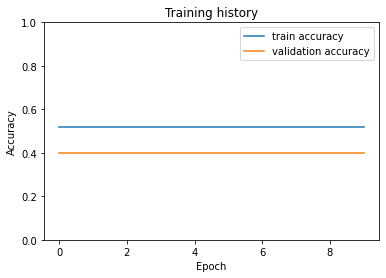

In [54]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  criterion,
  device,
  len(test_df)
)

test_acc.item()

  0%|          | 0/3 [00:00<?, ?it/s]

0.25

In [67]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in tqdm(data_loader):

      texts = d["title"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      # probs = nn.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      # prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  # prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, real_values

In [68]:
y_review_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         5
         1.0       0.00      0.00      0.00        15

    accuracy                           0.25        20
   macro avg       0.12      0.50      0.20        20
weighted avg       0.06      0.25      0.10        20

